# Prediction Problems

## Loading the dataset

In [97]:
import os

import pandas as pd

import holcrawl.shared

In [2]:
dataset_dir = holcrawl.shared._get_dataset_dir_path()

In [3]:
dataset_path = os.path.join(dataset_dir, 'movies_dataset.csv')

In [4]:
df = pd.read_csv(dataset_path)

## Feature Generation

In [5]:
df['total_screens'] = df['avg_screens'] * df['num_weekends'] 

In [6]:
df['norm_gross'] = df['gross_income'] / df['budget']

In [72]:
df['starting_letter'] = df['name'].map(lambda name: name[0].lower())

In [73]:
df['name_lenth'] = df['name'].map(lambda name: len(name))

In [183]:
len(df)

338

In [186]:
# df.isnull().sum()

In [185]:
len(df[df['avg_mc_critic_by_opening'].notnull()])

335

In [74]:
# df['opening_weekend_date']

In [119]:
BASE_FEAT_TO_KEEP = [
    'duration', 'starting_letter', 'budget', 'opening_month', 'opening_day', 'opening_day_of_year', 'year',
    'avg_mc_critic_by_opening', 'name_lenth'  # 'avg_mc_user_by_opening'
]

In [120]:
FEAT_TO_KEEP = BASE_FEAT_TO_KEEP + [col for col in df.columns if 'genres' in col]

In [121]:
features = df.drop([col for col in df.columns if col not in BASE_FEAT_TO_KEEP], axis=1)

In [160]:
features['norm_gross'] = df['norm_gross']

In [77]:
dataset = df.drop([col for col in df.columns if col not in FEAT_TO_KEEP], axis=1)

In [78]:
letter_dummies = pd.get_dummies(dataset['starting_letter'], drop_first=True, prefix='fl')

In [79]:
dataset = dataset.assign(**{col: letter_dummies[col] for col in letter_dummies.columns})

In [80]:
dataset = dataset.drop('starting_letter', axis=1)

In [81]:
dataset = dataset.dropna(axis=0)

In [122]:
# dataset

In [ ]:
# pd.options.display.max_columns = 999
# dataset

## Exploration

In [126]:
import numpy as np

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [162]:
def draw_pearson_correlation(feature_df):
    pearson_df = pd.DataFrame(
        data=np.corrcoef(feature_df.T),
        index=feature_df.columns,
        columns=feature_df.columns
    )
    
    lower_left_mask = []
    for i in range(len(feature_df.columns)):
        lower_left_mask.append([i<j+1 for j in range(len(feature_df.columns))])
    lower_left_mask = np.array(lower_left_mask)
    
    plt.figure(figsize=(13,10))
    with sns.axes_style("white"):
        heatmap = sns.heatmap(
            pearson_df, 
            annot=True, 
            fmt=".2f", 
            linewidths=.5,
#             mask=lower_left_mask
        )
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), fontsize=14);
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
        

In [152]:
# features = features.drop('starting_letter', axis=1)

In [157]:
features = features.dropna(axis=0)

In [158]:
features.columns

Index(['budget', 'duration', 'year', 'avg_mc_critic_by_opening',
       'opening_month', 'opening_day', 'opening_day_of_year', 'name_lenth'],
      dtype='object')

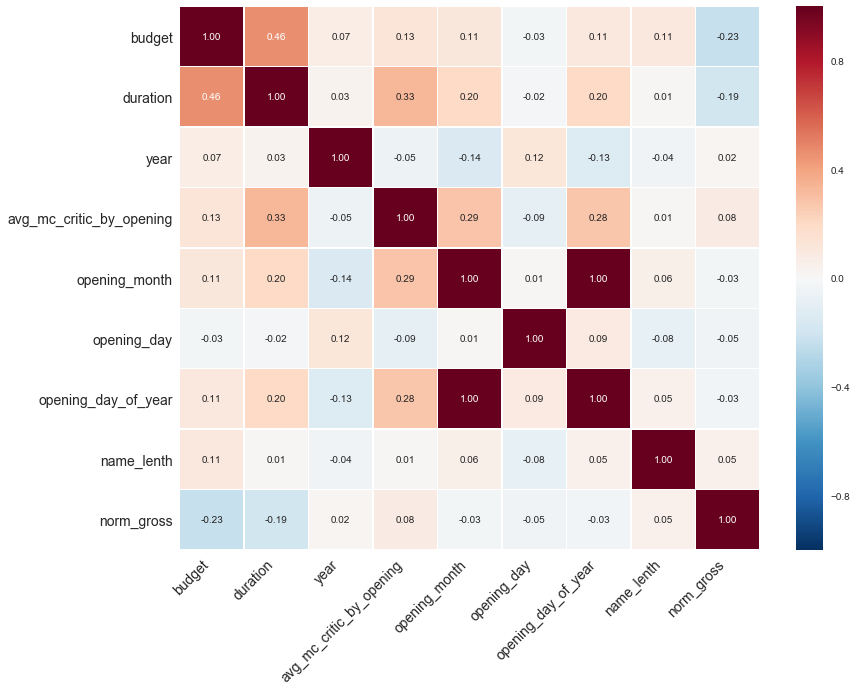

In [163]:
draw_pearson_correlation(features)

## Prediction

In [106]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from scipy.special import expit

### Predicting failed movies

In [169]:
failed = df['norm_gross'].ix[dataset.index] < 1

In [170]:
X = dataset
Y = failed

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

In [178]:
logreg = linear_model.LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [179]:
mean_accuracy = logreg.score(X_test, y_test)
mean_accuracy

0.56338028169014087

In [180]:
y_predict = logreg.predict(X_test)
confidence = logreg.decision_function(X_test)
expit_confidence = expit(logreg.decision_function(X_test))
probablility = logreg.predict_proba(X_test)[:, 1]
# log_res['decision'] = logreg.decision_function(x_test)
coef_df = pd.DataFrame({'coef': logreg.coef_[0]}, index=X_train.columns)

In [181]:
coef_df

,coef
budget,-1.185395e-09
duration,-2.284065e-06
year,-4.272609e-05
genres.action,1.511790e-08
genres.adventure,-4.453006e-09
genres.animation,-2.562034e-09
genres.biography,-5.104862e-09
genres.comedy,-1.974960e-08
genres.crime,6.318081e-09
genres.documentary,-2.402305e-09


## Predicting return on investment

In [117]:
dataset

Index(['budget', 'duration', 'year', 'genres.action', 'genres.adventure',
       'genres.animation', 'genres.biography', 'genres.comedy', 'genres.crime',
       'genres.documentary', 'genres.drama', 'genres.family', 'genres.fantasy',
       'genres.history', 'genres.horror', 'genres.music', 'genres.musical',
       'genres.mystery', 'genres.romance', 'genres.sci-fi', 'genres.sport',
       'genres.thriller', 'genres.war', 'genres.western',
       'avg_mc_critic_by_opening', 'opening_month', 'opening_day',
       'opening_day_of_year', 'name_lenth', 'fl_2', 'fl_3', 'fl_4', 'fl_5',
       'fl_a', 'fl_b', 'fl_c', 'fl_d', 'fl_e', 'fl_f', 'fl_g', 'fl_h', 'fl_i',
       'fl_j', 'fl_k', 'fl_l', 'fl_m', 'fl_n', 'fl_o', 'fl_p', 'fl_r', 'fl_s',
       'fl_t', 'fl_u', 'fl_v', 'fl_w'],
      dtype='object')

In [109]:
X = dataset
Y = df['norm_gross'].ix[dataset.index]

In [110]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [112]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

/Users/shaypalachy/miniconda3/envs/ds/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [115]:
coef_df = pd.DataFrame({'coef': regr.coef_[0]}, index=X_train.columns)
coef_df

In [116]:
regr.score(X_test, y_test) 

-0.93319393276110452